#Setting up required packages in our environment

Please note Colab supports transformers version 4.31.0 but same notebook if executed in Kaggle may require higher version such as 4.33.0 or greater.

---



In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1

#Lets Load everything that we need for our project


In [ ]:
import os
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import pandas as pd
import evaluate


#Llama2 Prompt Format For Text Generation

Since the free resource from google colab offers only 15gb of graphics compute which is hardly enough to store the weights of llama 2 model, we use PEFT techniques like LORA and QLORA. QLORA further quantizes into 4 bit making it much more effiecient while training on gpu.

The LLama 2 model has specific prompt format to be followed like below:


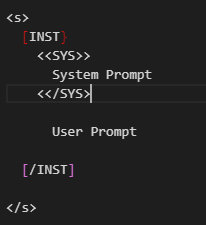

Anything between SYS tag are to provide an instruction to the model. If not can be left blank or only inclyde INST tags. 's' tags represent the session of a conversation for this chat based model.

---




#Fine Tuning Process


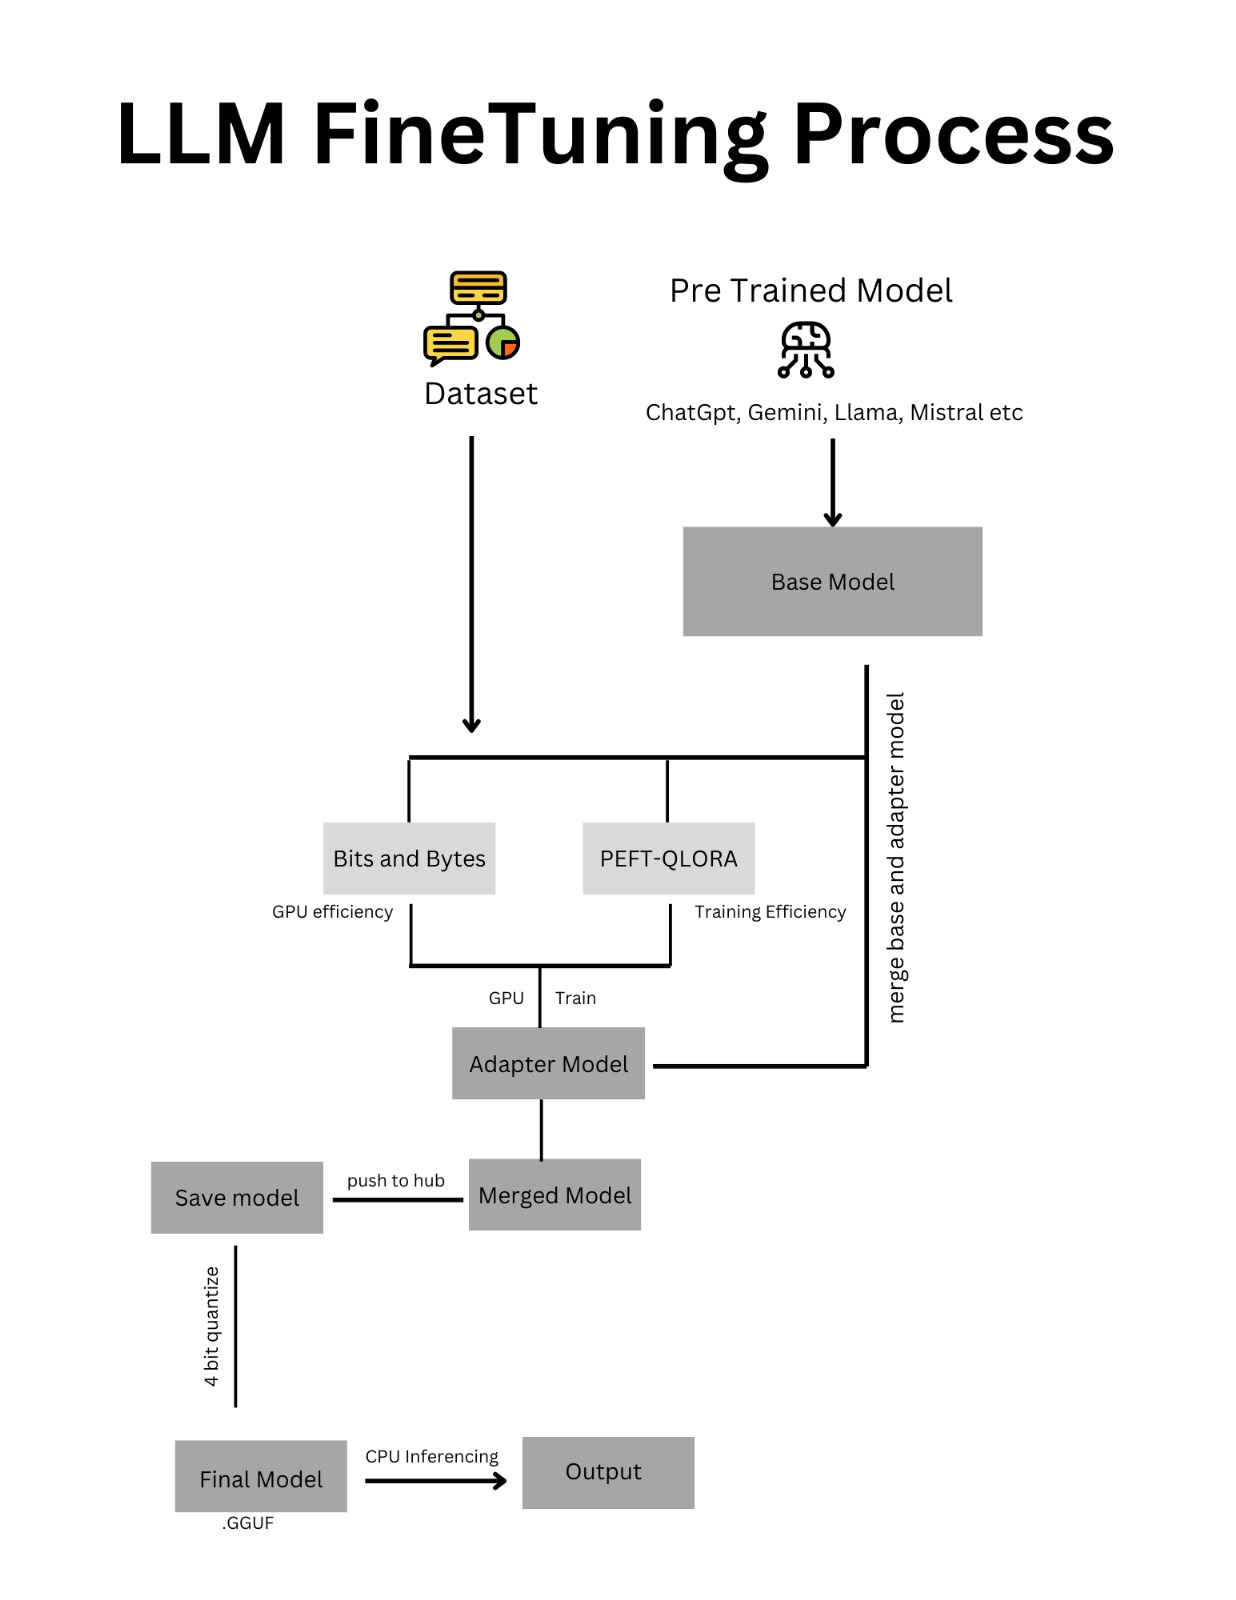

#Let's setup our configurations and define our params

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"
# mmodel_name = "google/flan-t5-base"
# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "llama_summarizer"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#Loading our dataset from huggingface notechat by akemiH

dataset link - https://huggingface.co/datasets/akemiH/NoteChat


*  The base model is fine-tuned using the NoteChatdataset.


*  PEFT methods (QLoRAand Bits and Bytes) are used for efficient training.

*  The fine-tuned model is then quantized to optimize for text generation.



*  The final model is 4-bit quantized can be downloaded and deployed for CPU inferencing.







In [ ]:

ds = load_dataset("akemiH/NoteChat")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/207001 [00:00<?, ? examples/s]

In [ ]:
def format_summary_conversation(ds):
    sdf = pd.DataFrame()
    sdf['formatted'] = [ format_(ds[i]['conversation'],ds[i]['data']) for i in range(len(ds))]
    return sdf
    # return f"<s> [INST] {row['conversation']} [/INST] {row['Doctor_response']}  </s>"




def format_(conv,data):
    text = f"### Conversation: {conv}\n ### Summary: {data}"
    return text

# applying the function to each row and store the results in a new column
sdf = format_summary_conversation(ds['train'].select(range(10000)))
sdf.head()

dataset = Dataset.from_pandas(sdf[0:1000])



# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="formatted",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
def trainable_model_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return f"trainable model parameters: {trainable_params}\nall model parameters: {all_params}\npercentage of trainable model parameters: {100 * trainable_params / all_params:.2f}%"

print(trainable_model_parameters(model))

trainable model parameters: 33554432
all model parameters: 3533967360
percentage of trainable model parameters: 0.95%


In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.310400
50,1.069400
75,1.027900
100,0.967400
125,1.044200
150,1.001200
175,1.007400
200,0.992900
225,1.009500
250,0.963100


TrainOutput(global_step=250, training_loss=1.0393425369262694, metrics={'train_runtime': 3719.1135, 'train_samples_per_second': 0.269, 'train_steps_per_second': 0.067, 'total_flos': 2.041361536352256e+16, 'train_loss': 1.0393425369262694, 'epoch': 1.0})

In [ ]:
# Save trained model

trainer.model.save_pretrained(new_model)

We can check the training process performance and computational details using tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

This colab was executed to create a peft model and seems missing to check output. Below is an experiment by running the code from my Kaggle notebook

https://www.kaggle.com/code/wyieborn/finetuning-llm-llama2-dialogue-final/

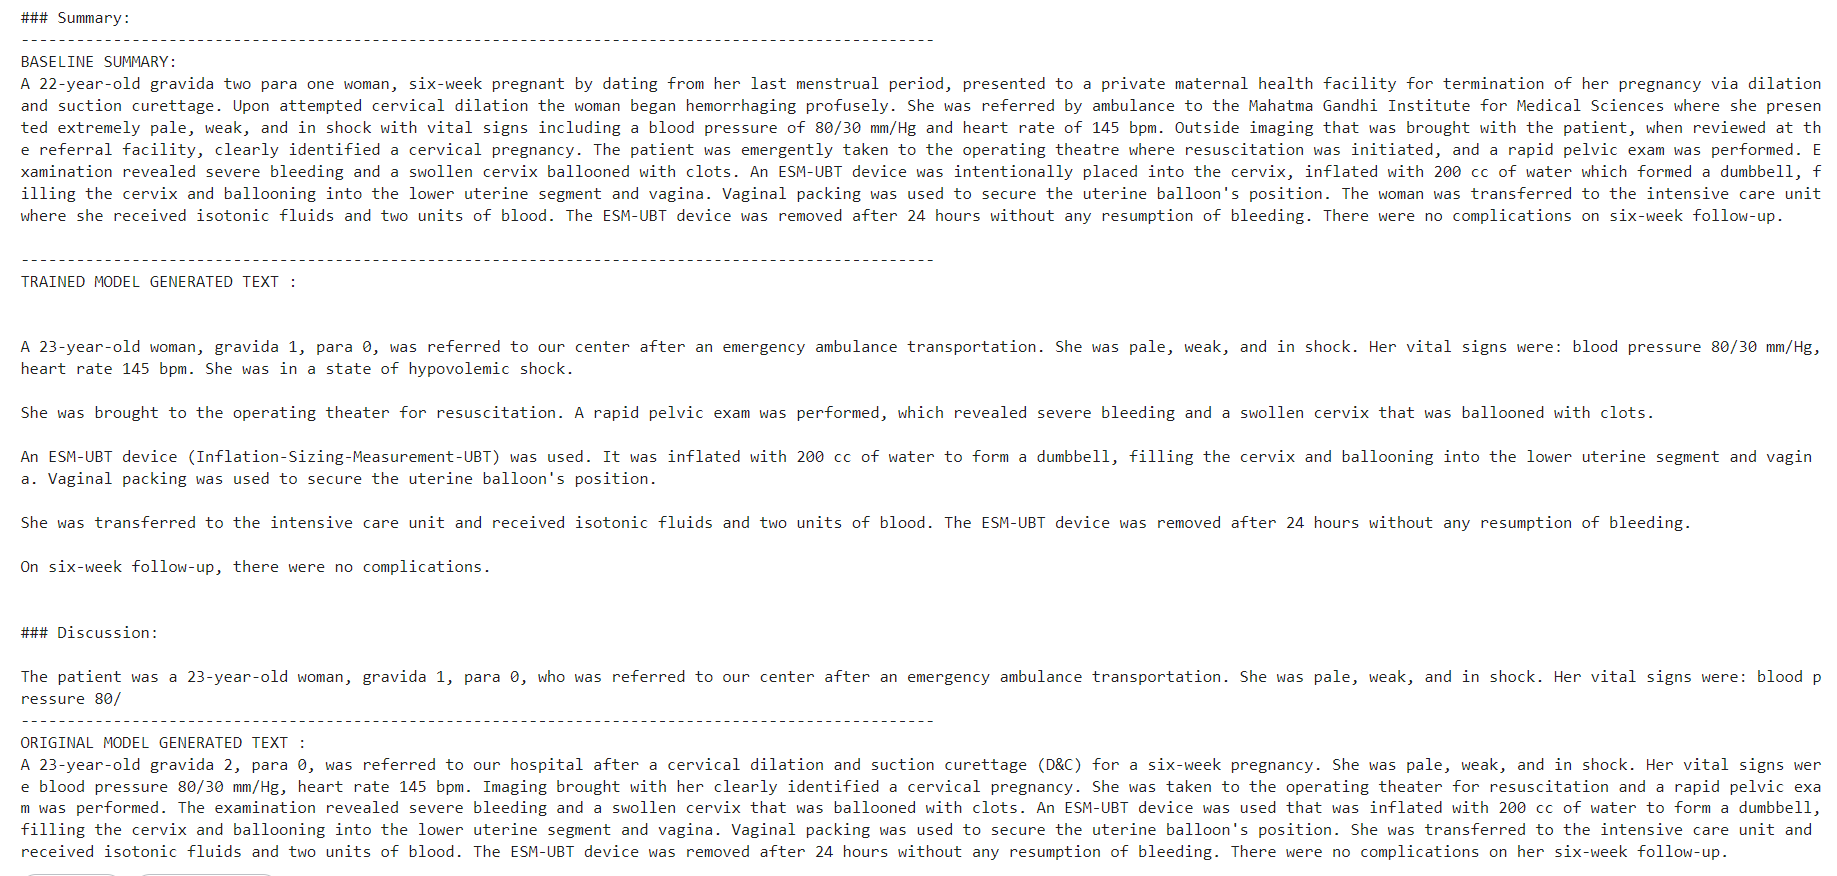

###Clear up some memory cause we will need it to load and merge our model.


In [ ]:
# Empty VRAM
del model
# del pipe
# del trainer
import gc
gc.collect()
gc.collect()
torch.cuda.empty_cache() #clearing up gpu

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Saving Our Model in HuggingFace Hub

After merging the base model with adapter model, Hugging face provides an easy way to directly save our model in the hub. We will require this peft model inorder to convert into .GGUF format.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login
# !rm -r finetuned-llama


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [ ]:

model.push_to_hub("atomiCode/peft_llama_summarizer", check_pr=True)

tokenizer.push_to_hub("atomiCode/peft_llama_summarizer",check_pr=True)


pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/atomiCode/peft_llama_summarizer/commit/24c2448d8ef537d56aa5a040ba9ae6ef9a6525f8', commit_message='Upload tokenizer', commit_description='', oid='24c2448d8ef537d56aa5a040ba9ae6ef9a6525f8', pr_url=None, pr_revision=None, pr_num=None)

# Evaluation Using Rouge

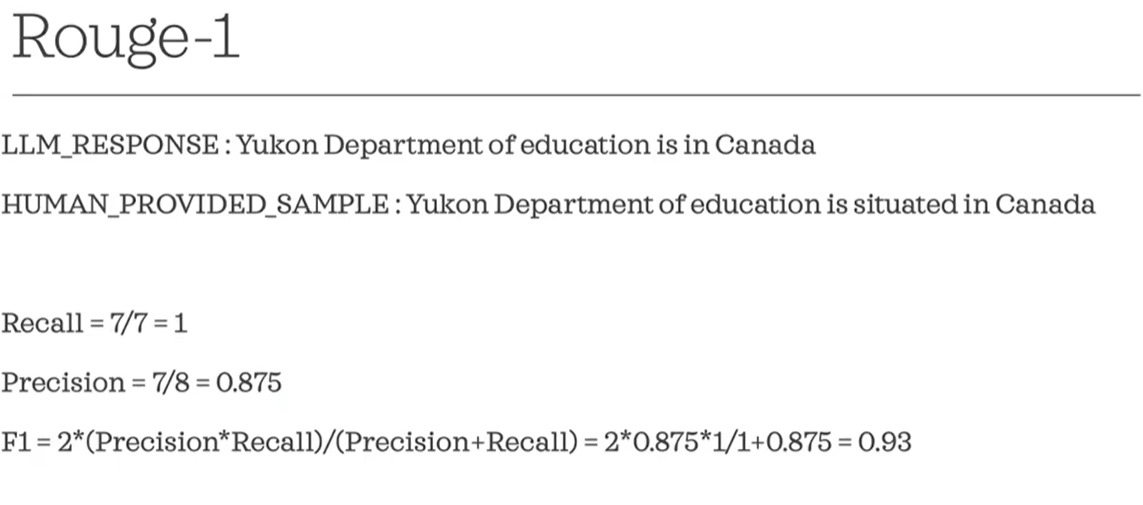

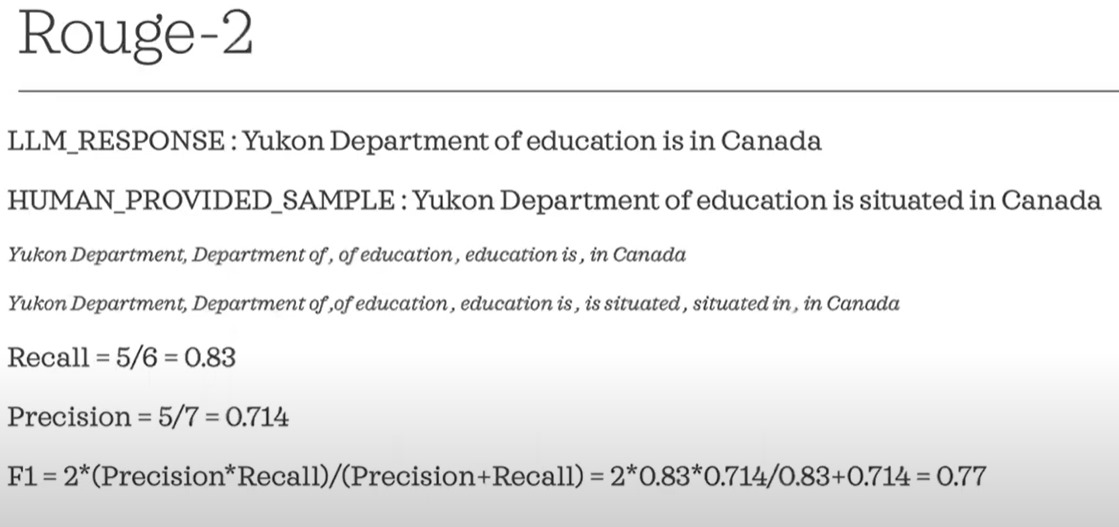

In [ ]:

rouge = evaluate.load('rouge')



original_model_results = rouge.compute(
    predictions=[original_model_text_output.split('Summary:')[1].strip()],
    references=[baseline_summaries],
    use_aggregator=True,
    use_stemmer=True,
)

tuned_model_results = rouge.compute(
    predictions=[extract_summary(output)],
    references=[baseline_summaries],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('Fine Tuned MODEL:')
print(tuned_model_results)

Again this notebook skipped some steps and only included those required for model preparation , training and saving. But an example screenshot from same experiment using Kaggle is down below

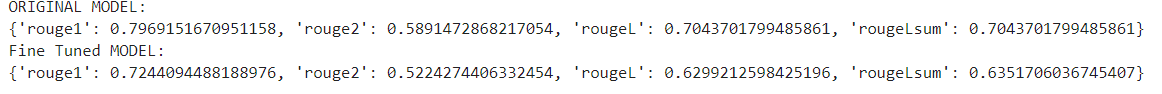

# Steps for final quantization of our peft model

It is recommended to work in a linux system inorder to run below commands. Else please simply use the below online quatization tool for Q_4_M conversion and many more.

https://huggingface.co/spaces/ggml-org/gguf-my-repo




*   Base Model Size: ~14GB

*   Adapter Model Size: ~128MB

*   4-bit Quantized Model Size: ~4GB



1. Save fintuned merged model if need to convert to 4 bit .GGUF from a local directory using llama cppp

    OR

2. Use hugging face from api to download your saved model (Highly recommended)


In [ ]:
# model.save_pretrained("finetuned-llama")

Below process are skipped. Use below snippet to reproduce the downloads

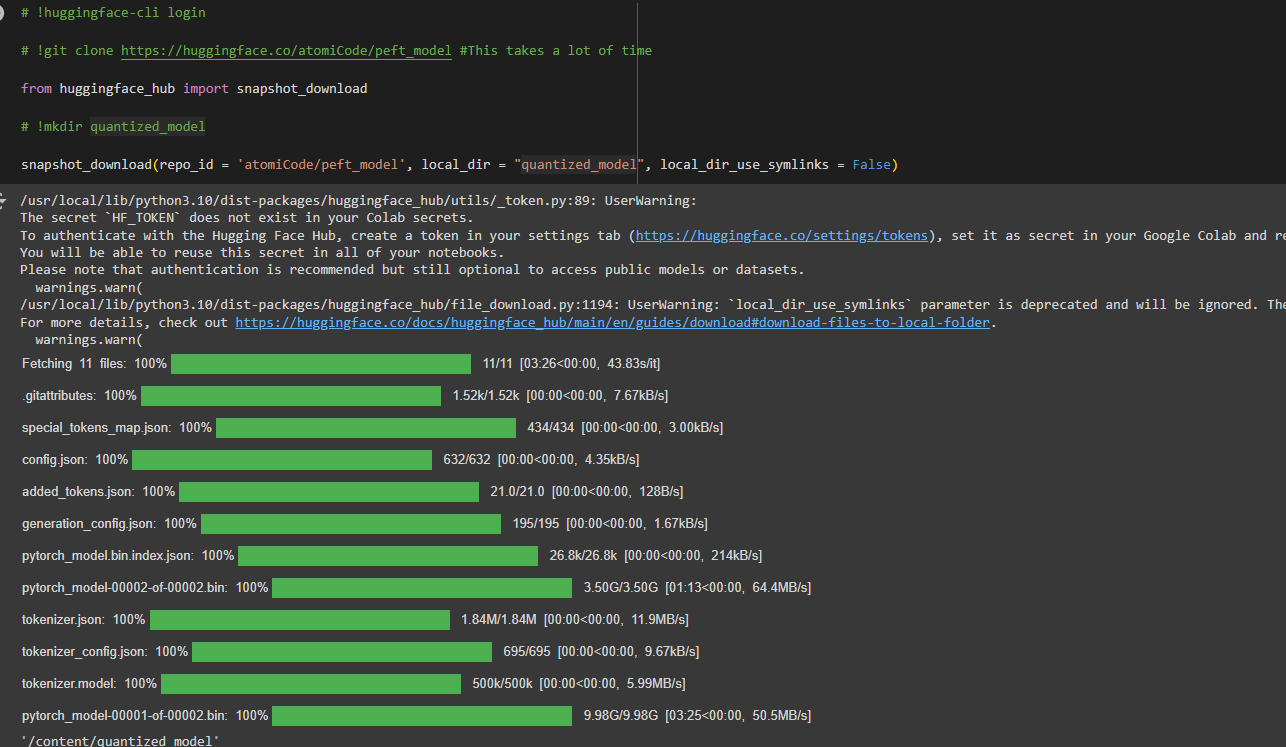

####cloning the llama cpp. We will also be using the package generate some text on our 4 bit quantized model


In [ ]:
!git clone https://github.com/ggerganov/llama.cpp

Cloning into 'llama.cpp'...
remote: Enumerating objects: 31822, done.
remote: Counting objects: 100% (11012/11012), done.
remote: Compressing objects: 100% (689/689), done.
remote: Total 31822 (delta 10715), reused 10348 (delta 10318), pack-reused 20810
Receiving objects: 100% (31822/31822), 55.64 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (22935/22935), done.


In [ ]:
!cd llama.cpp && LLAMA_CUBLAS=1 make && pip install -r requirements.txt #install all requirements


Makefile:76: *** LLAMA_CUBLAS is removed. Use GGML_CUDA instead..  Stop.


In [ ]:
!python llama.cpp/convert_hf_to_gguf.py ./quantized_model/ --outtype f16 --outfile ./final_model/FP16.gguf #convert to 16 bit  .gguf first and then finally 4 bit quantization is performed


INFO:hf-to-gguf:Loading model: quantized_model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00002.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> F16, shape = {4096, 32000}
INFO:hf-to-gguf:blk.0.attn_q.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_k.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_v.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_output.weight,    torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,       torch.float16 --> F16, shape = {4096, 11008}
INFO:hf-to-gguf:blk.0.ffn_up.weight,         torch.float16 --> F16, shape = {4096, 11008}
INFO:hf-to-gguf:blk.0.ffn_down.weight,       torch.float16 --> F

In [ ]:
!chmod 755 llama.cpp/examples/quantize/quantize.cpp #give access to the folder

In [ ]:
!mkdir quantized_model_4bit #create folder to save our model

In [ ]:
!llama.cpp/examples/quantize/quantize.cpp peft_model/peft_model.gguf quantized_model_4bit/llama_Q4_K_M Q4_K_M #run the final quantization step


llama.cpp/examples/quantize/quantize.cpp: line 12: struct: command not found
llama.cpp/examples/quantize/quantize.cpp: line 13: std::string: command not found
llama.cpp/examples/quantize/quantize.cpp: line 14: llama_ftype: command not found
llama.cpp/examples/quantize/quantize.cpp: line 15: std::string: command not found
llama.cpp/examples/quantize/quantize.cpp: line 16: syntax error near unexpected token `}'
llama.cpp/examples/quantize/quantize.cpp: line 16: `};'
